# 投资组合

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import matplotlib . pyplot as plt
from matplotlib import style
style.use('ggplot')

%matplotlib inline 

start = dt.datetime(2017, 1, 1)
end = dt.datetime.now()

C:\Users\Acer\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
symbols = ['AAPL' , 'MSFT' , 'DB' , 'GLD']
noa = len(symbols)

In [4]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, 'yahoo',start, end)['Adj Close']
data.columns = symbols 

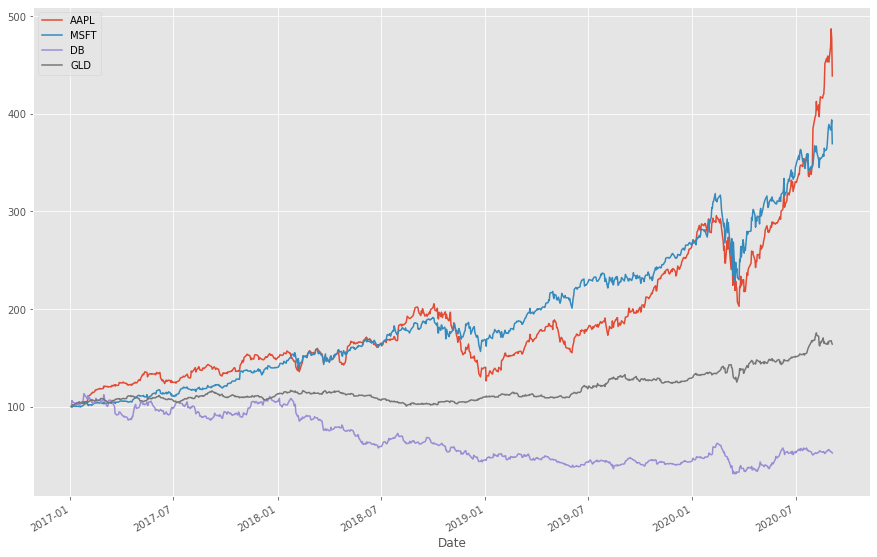

In [5]:
(data / data.iloc[0] * 100).plot(figsize=(15, 10)) 

In [6]:
#均值，方是指的是不同证券(对数)收益的均值和方差，可以这样计
rets = np.log(data / data.shift(1)) 

In [7]:
#我们使用 252 个交易口，从每日收益得出年化收益:
rets.mean()*252

AAPL    0.403324
MSFT    0.356367
DB     -0.176164
GLD     0.134871
dtype: float64

In [8]:
#协方差矩阵:
rets.cov() * 252 

,AAPL,MSFT,DB,GLD
AAPL,0.096904,0.067313,0.057255,0.000432
MSFT,0.067313,0.083616,0.054175,0.000858
DB,0.057255,0.054175,0.178557,-0.002244
GLD,0.000432,0.000858,-0.002244,0.017132


In [9]:
weights = np.random .random(noa)
weights /= np.sum(weights) 
weights

array([0.28273212, 0.08683405, 0.52397319, 0.10646064])

In [10]:
#投资的标准差(波动率)
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) 

0.28737386888511723

In [11]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T,
    np.dot(rets.cov() * 252, weights))))
    
    
prets = np.array(prets)
pvols = np.array(pvols)

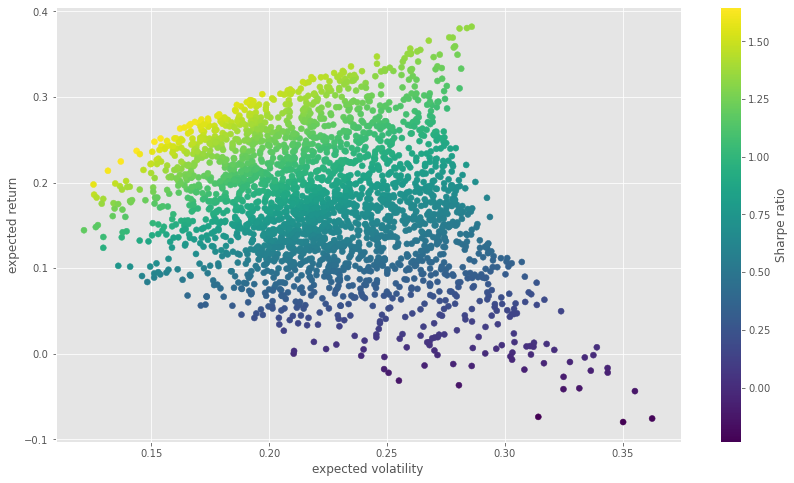

In [12]:
plt.figure(figsize=(14, 8))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# 投资组合优化

In [13]:
def statistics(weights):
    '''Returns portfolio statistics.
    Parameters
    ==========
    weights : array-like
    weights for different securities in portfolio
    Returns
    =======
    pret : float
    expected portfolio return
    pvol : float
    expected portfolio volatility
    pret / pvol : float
    Sharpe ratio for rf=0
    ''' 
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])


Let us start with the maximization of the Sharpe
ratio. Formally, we minimize the negative value of the Sharpe ratio:

In [14]:
import scipy.optimize as sco

def min_func_sharpe(weights):
    return -statistics(weights)[2]

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))


In [15]:
noa * [1. / noa,]

[0.25, 0.25, 0.25, 0.25]

In [16]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)


Wall time: 103 ms


In [17]:
opts

     fun: -1.6889769822036254
     jac: array([ 1.88052654e-05,  1.13993883e-05,  3.11492693e+00, -9.59634781e-06])
 message: 'Optimization terminated successfully'
    nfev: 52
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([2.23097542e-01, 1.56964598e-01, 1.20915647e-16, 6.19937860e-01])

In [18]:
print(opts['x'].round(3))
print(statistics(opts['x']).round(3))

[0.223 0.157 0.    0.62 ]
[0.23  0.136 1.689]


# =======================
Let us minimize the variance of the portfolio

In [19]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

optv = sco.minimize(min_func_variance, noa * [1. / noa,],method='SLSQP', bounds=bnds,constraints=cons)


In [20]:
optv

     fun: 0.013964232562119493
     jac: array([0.02733106, 0.02834329, 0.02785906, 0.02791472])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.04345125, 0.0970798 , 0.04486075, 0.8146082 ])

In [21]:
print(optv['x'].round(3))
print(statistics(optv['x']).round(3))

[0.043 0.097 0.045 0.815]
[0.154 0.118 1.304]


# 有效边界

In [22]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

def min_func_port(weights):
    return statistics(weights)[1]

In [23]:
%%time
trets = np.linspace(0.0, 0.3, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    
    
    
tvols = np.array(tvols)


Wall time: 3.85 s


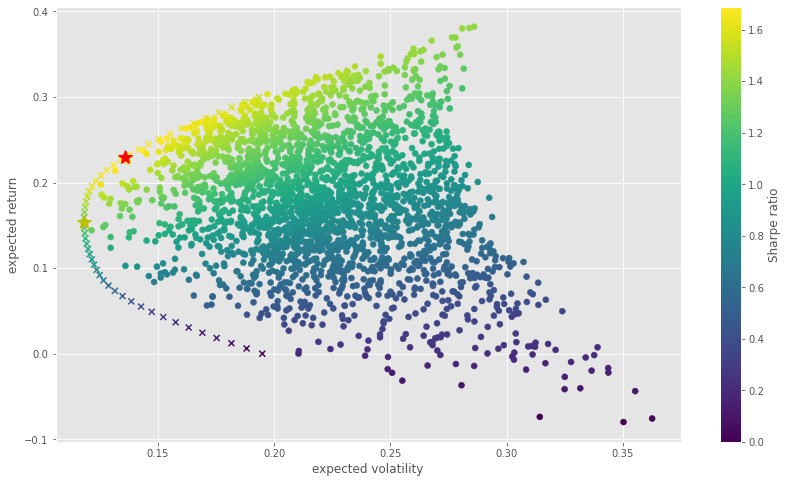

In [24]:
plt.figure(figsize=(14, 8))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(tvols, trets,c=trets / tvols, marker='x')
# efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

资本市场线

In [25]:
import scipy.interpolate as sci 


In [26]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:] 

In [28]:
tck = sci.splrep(evols, erets)

In [33]:
def f(x):
#Efficient frontier function (splines approx mation).
    return sci.splev(x, tck , der=0)

def df(x):
#First derivative of efficient frontier function.'''
    return sci.splev(x, tck, der=1) 

In [55]:
def equations(p, rf=0.04):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3


In [56]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [57]:
opt

array([0.04      , 1.40381548, 0.14592008])

In [58]:
np.round(equations(opt), 6)

array([ 0., -0., -0.])

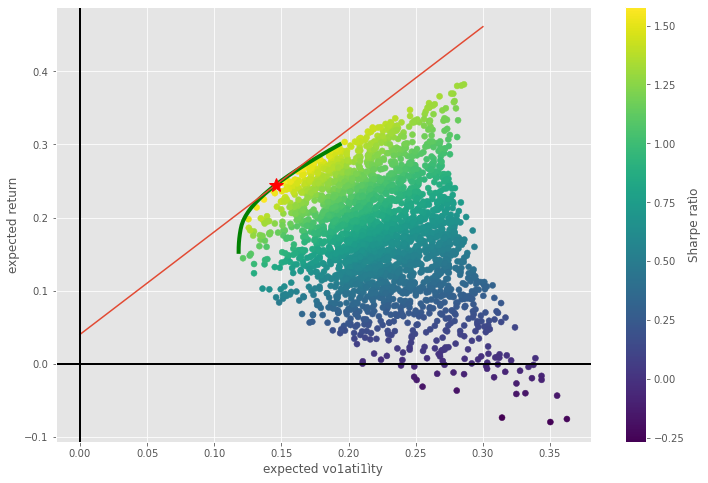

In [59]:
plt.figure(figsize=(12, 8))
plt.scatter(pvols, prets , c=(prets - 0.01) / pvols, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'g' , lW=4.0)
# efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx , lw=1.5)
# capital market line
plt.plot(opt[2] , f(opt[2]) , 'r*' , markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k' , ls= '-', lw=2.0)
plt.axvline(0, color='k' , ls= '-', lw=2.0)
plt.xlabel('expected vo1ati1ìty')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratìo') 